# Crime by Neighborhood
### By Jack Cetani
Dataset: [Police Incident Blotter (30 Day)](https://data.wprdc.org/dataset/police-incident-blotter)

As a group, we will be attempting to determine the best Pittsburgh neighborhood for kids using three metrics: parks, schools, and crime.

In this notebook, Pittsburgh police incident data will be analyzed to come to a conclusion on the safety of each Pittsburgh neighborhood. With this conclusion, we can find which neighborhoods are safer for children and use it in our overall metric.

In [1]:
# import pandas and geopandas
import pandas as pd
import geopandas as gpd

In [2]:
# read neighborhood shape file
neighborhood_map = gpd.read_file("Neighborhoods_.shp")

In [3]:
# read dataset
incident_data = pd.read_csv("police_incidents.csv")
incident_data.head(5)

,PK,CCR,HIERARCHY,INCIDENTTIME,INCIDENTLOCATION,CLEAREDFLAG,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTHIERARCHYDESC,OFFENSES,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y
0,306530435,23035798,6,2023-03-10T11:30:00,"600 Block Penn Ave Pittsburgh, PA 15222",N,Central Business District,2,THEFT,3921 Theft by Unlawful Taking or Disposition.,201.0,6.0,6.0,-80.001793,40.442593
1,307051774,23038735,10,2023-03-16T09:35:00,"800 Block Reunion Pl Pittsburgh, PA 15219",N,Bedford Dwellings,2,TERRORISTIC THREATS,2706 Terroristic Threats. / 2709(a) Harassment.,509.0,NaN,NaN,NaN,NaN
2,307082554,23038816,27,2023-03-16T12:45:00,"N Braddock Ave & Alsace Way Pittsburgh, PA 15208",N,Homewood South,5,HIT AND RUN,3745 Accidents Involving Damage to Unattended ...,1303.0,9.0,2.0,-79.891415,40.452384
3,307106971,23038916,99,2023-03-16T12:00:00,"1400 Block Locust St Pittsburgh, PA 15219",N,Bluff,2,MISSING PERSONS (18+),9490 Missing Persons (18 and Over),103.0,6.0,3.0,-79.985459,40.436044
4,307112015,23038967,6,2023-03-16T17:54:00,"900 Block Liberty Ave Pittsburgh, PA 15222",N,North Oakland,2,RETSIL THEFT (SHOPLIFTING),"3929(a)(1) Retail Theft; takes possession of, ...",403.0,6.0,6.0,-79.997939,40.442945


In order to find the neighborhood with the least crime from this dataset, we could use the columns "HEIRARCHY" and "INCIDENTNEIGHBORHOOD". By figuring out the average crime heirarchy for each neighborhood, we can get an idea of how safe each neighborhood would be for kids.

In [4]:
# creating a dictionary containing the mean crime heirarchy for each neighborhood
heirarchy_dictionary = incident_data.groupby("INCIDENTNEIGHBORHOOD").mean()["HIERARCHY"]
heirarchy_dictionary.sort_values(ascending=True)

INCIDENTNEIGHBORHOOD
New Homestead            0.000000
Regent Square            0.000000
Esplen                   0.000000
East Carnegie            0.000000
Outside State            2.000000
                          ...    
Mount Oliver            43.000000
Chateau                 46.709677
Polish Hill             47.400000
Point Breeze            47.666667
California-Kirkbride    56.842105
Name: HIERARCHY, Length: 92, dtype: float64

After creating this dictionary, we can see that 4 neighborhoods have no crime heirarcy. These would be obvious choices for safest neighborhood, but to make sure we are collecting data correctly and there are not other reasons as to why these neighborhoods have such a low crime heirarchy, lets also find the crime count for each neighborhood.

In [5]:
# creating a dictionary containing the crime count for each neighborhood
crime_count_dictionary = incident_data['INCIDENTNEIGHBORHOOD'].value_counts().sort_values(ascending=False)
crime_count_dictionary.sort_values(ascending=True)

East Carnegie                  1
Ridgemont                      1
Esplen                         2
Regent Square                  2
New Homestead                  3
                            ... 
Marshall-Shadeland            74
East Liberty                  84
Carrick                       91
South Side Flats             125
Central Business District    374
Name: INCIDENTNEIGHBORHOOD, Length: 92, dtype: int64

With this new crime count dictionary, we can see that these neighborhoods do in fact have crime, just not much of it, which is good for our case. Since the average crime heirarchy for the first 4 neighborhoods are all 0, the crime count can tell us which neighborhood among the 4 are safer, being East Carnegie. Although, for the sake of plotting our data and coming to a conclusion from it, we'll assume this difference is negligible. Therefore, we can already give an answer to the safest neighborhood(s) in Pittsburgh, being:
* East Carnegie
* New Homestead
* Esplen
* Regent Square

Now, lets play around with our data by first putting it into a data frame.

In [6]:
# merge both the heirarchy and crime count dictionaries into one
neighborhood_crime_dictionary = {'Average Crime Heirarchy': heirarchy_dictionary, 
                           'Crime Count' : crime_count_dictionary}
# turn dictionary into data frame
neighborhood_crime_data = pd.DataFrame(neighborhood_crime_dictionary)

In [7]:
# change the neighborhoods from an index to a column
neighborhood_crime_data.reset_index(inplace=True)
neighborhood_crime_data = neighborhood_crime_data.rename(columns = {'index':'Neighborhood'})
neighborhood_crime_data = neighborhood_crime_data.sort_values('Crime Count', ascending = True)

Although it's not exactly what were basing out conclusion on, lets plot the 20 neighborhoods with the lowest crime count.

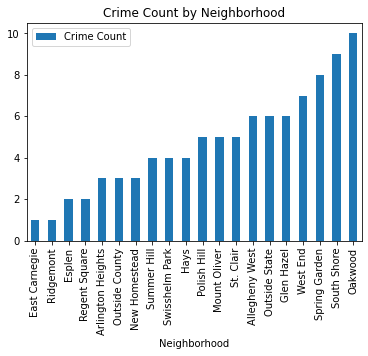

In [8]:
crime_count_bar = neighborhood_crime_data.iloc[:20].plot(kind='bar', x="Neighborhood", y="Crime Count", title="Crime Count by Neighborhood")

Now lets do the same with the average crime heirarchy.

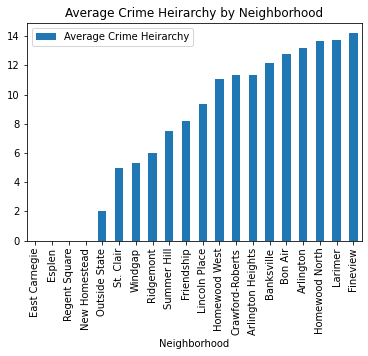

In [9]:
crime_heirarchy_data_sorted = neighborhood_crime_data.sort_values('Average Crime Heirarchy', ascending = True)
crime_heirarchy_bar = crime_heirarchy_data_sorted.iloc[:20].plot(kind='bar', x="Neighborhood", y="Average Crime Heirarchy", title="Average Crime Heirarchy by Neighborhood")

Now lets compare the two.

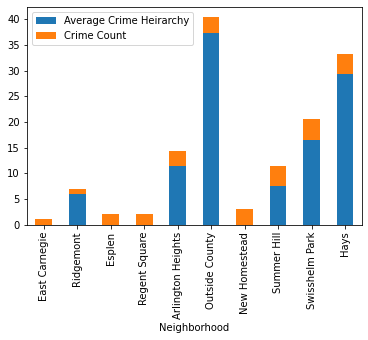

In [10]:
neighborhood_crime_data.iloc[0:10].plot.bar(stacked = True, x = "Neighborhood")

It looks like crime count and average crime heirarchy correlate pretty well. However, the average crime heirarchy is definitley a better gauge of safety.

Now, in order to come together and come to a conclusion about the best neighborhood for kids, each neighborhood must be ranked on a scale from 1 to 0, 1 being the most optimal neighborhood for each dataset.

Therefore, the goal now is to rank the neighborhoods on this scale, with 1 being the safest.

We can do this by finding the highest average crime heirarchy, subtracting it from each neighborhoos average, and then putting it over this max heirarchy value again.

In [11]:
# finding and setting the highest average crime heirarchy
maxValue = float(neighborhood_crime_data['Average Crime Heirarchy'].max())
print(maxValue)

56.8421052631579


We can see that the highest average crime heirarchy is 56.84, which is the max value we will be using to calculate the scores for each neighborhood.

Lets also add a column for this "overall score" to our data frame.

In [12]:
# adding overall score column
neighborhood_crime_data["Overall Score"] = 0
neighborhood_crime_data.head(5)

,Neighborhood,Average Crime Heirarchy,Crime Count,Overall Score
25,East Carnegie,0.000000,1,0
68,Ridgemont,6.000000,1,0
29,Esplen,0.000000,2,0
67,Regent Square,0.000000,2,0
4,Arlington Heights,11.333333,3,0


Now lets iterate through our data frame and set the overall score for each neighborhood.

In [13]:
for i, row in neighborhood_crime_data.iterrows():
    # calculating each neighborhoods overall score between 1 and 0
    overallScore = abs(float(row["Average Crime Heirarchy"]) - maxValue)/maxValue
    neighborhood_crime_data.at[i, "Overall Score"] = overallScore
    
neighborhood_crime_data.sort_values("Overall Score", ascending = False)

,Neighborhood,Average Crime Heirarchy,Crime Count,Overall Score
25,East Carnegie,0.000000,1,1.000000
29,Esplen,0.000000,2,1.000000
67,Regent Square,0.000000,2,1.000000
53,New Homestead,0.000000,3,1.000000
60,Outside State,2.000000,6,0.964815
...,...,...,...,...
51,Mount Oliver,43.000000,5,0.243519
20,Chateau,46.709677,31,0.178256
66,Polish Hill,47.400000,5,0.166111
64,Point Breeze,47.666667,21,0.161420


This overall score seems to be a representation of the average crime heirarchy, which means we did it right.

Now all we have to do is put this data into the shape file by assigning each value to it's specific neighborhood.

In [14]:
# iterating through both data frames to match each neighborhood
for i, row in neighborhood_map.iterrows():
    for j, data in neighborhood_crime_data.iterrows():
        if (row['hood'] == data['Neighborhood']):
            # adding all three data points for each neighborhood
            neighborhood_map.at[i,'Overall Score'] = data['Overall Score']
            neighborhood_map.at[i,'Average Crime Heirarchy'] = data['Average Crime Heirarchy']
            neighborhood_map.at[i,'Crime Count'] = data['Crime Count']

neighborhood_map = neighborhood_map.sort_values('Overall Score', ascending = False)

Now lets plot the data with our shape file. Lets start with crime count.

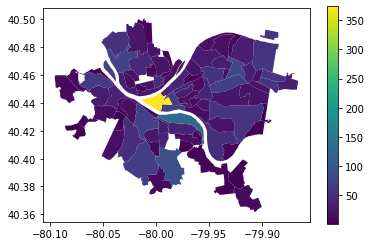

In [15]:
neighborhood_map.plot(column = "Crime Count", legend = True)

Now average crime heirarchy.

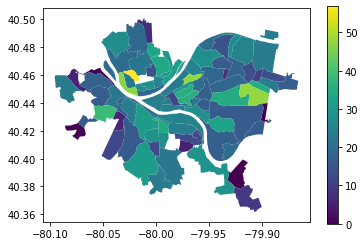

In [16]:
neighborhood_map.plot(column = "Average Crime Heirarchy", legend = True)

And now overall score.

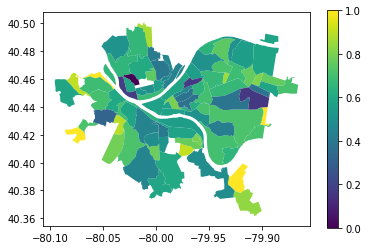

In [17]:
neighborhood_map.plot(column = "Overall Score", legend = True)

## Crime Conclusion:
Based off of our average crime heirarchy data, we can see that 4 neighborhoods seem to be the safest:
* East Carnegie
* New Homestead
* Esplen
* Regent Square

Again, if we wanted to get technical, we could say that East Carnegie is the safest as it has the lowest crime count out of the four. However, in order to ultimatelty find the best neighborhood for kids, the average crime heirarchy gives us the most information. Now that each neighborhood is given a score out of one, it can be used to get an overall score for each neighborhood based on my group members metrics as well. With that overall score, we'll be able to see which neighborhood is the best for kids.